# Imports

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

# Dataset Import

In [3]:
data_file = 'bmw_pricing_v2.csv'

In [4]:
original_df = pd.read_csv(data_file)

In [5]:
original_df.head()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,BMW,118,140411.0,100.0,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400.0,2018-04-01


In [6]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        4841 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               4842 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4831 non-null   object 
 7   tipo_coche                   4834 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4841 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  4839 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

In [7]:
original_df.isnull().sum()

marca                           2
modelo                          3
km                              2
potencia                        1
fecha_registro                  1
tipo_gasolina                   5
color                          12
tipo_coche                      9
volante_regulable               4
aire_acondicionado              2
camara_trasera                  2
asientos_traseros_plegables     4
elevalunas_electrico            2
bluetooth                       4
gps                             0
alerta_lim_velocidad            2
precio                          6
fecha_venta                     1
dtype: int64

# Data preparation

## Columna Marca

In [164]:
# Se trabaja con el format_df para empezar a manipular el dataset
format_df = original_df.copy()

In [165]:
# Como se trata de un dataset de BMW, se intuye que todos los coches serán de la misma marca
format_df['marca'].unique()

array(['BMW', nan], dtype=object)

In [166]:
# Se borra la columna porque, aunque tenga algunos nulos, todos los coches son de la misma marca
format_df.drop(columns = 'marca', inplace = True)

## Columnas de fecha

In [167]:
# Se detecta que las siguientes columnas contienen fechas:
glob_list_date = [column for column in format_df.columns if 'fecha' in column]

In [168]:
# Nulos de las columnas de fecha:
format_df[glob_list_date].isnull().sum()

fecha_registro    1
fecha_venta       1
dtype: int64

In [169]:
format_df[format_df[glob_list_date[0]].isnull()]

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
198,318,158853.0,100.0,NaN,diesel,black,estate,True,False,False,False,False,False,True,False,10900.0,2018-06-01


In [170]:
format_df[format_df[glob_list_date[1]].isnull()]

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
594,525,269290.0,120.0,2005-06-01,diesel,silver,estate,True,False,True,False,False,False,True,True,4200.0,NaN


Para rellenar los nulos, se decide calcular el tiempo medio entre la fecha de venta y la fecha de registro e imputar el valor que falta acorde al número calculado

In [171]:
# Se pasan las columnas a datetime
for column in glob_list_date:
    format_df[column] = pd.to_datetime(format_df[column])

In [172]:
# Se analiza la muestra del tiempo entre registro y venta
date_series = (format_df['fecha_venta'] - format_df['fecha_registro']).dt.days

In [173]:
# Parece que hay algún valor nulo y algún outlier
date_series.describe()

count     4841.000000
mean      1980.313365
std        932.297275
min      -2009.000000
25%       1489.000000
50%       1765.000000
75%       2130.000000
max      10258.000000
dtype: float64

<AxesSubplot:>

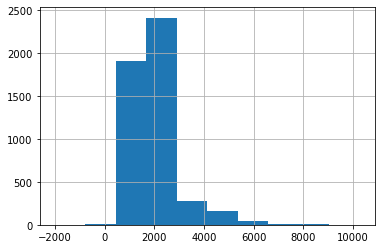

In [174]:
date_series.hist()

In [175]:
# Porcentaje de valores con fecha de registro posterior a la venta muy bajo
len(date_series[date_series < 0]) / len(date_series) * 100

0.08259343382201115

In [176]:
# Porcentaje de valores con fecha de venta superior a 8000 días a la fecha de registro
len(date_series[date_series > 8000]) / len(date_series) * 100

0.08259343382201115

In [177]:
# Se decide hacer la media con el 99% de los datos centrales
cuantil_bajo = np.nanquantile(date_series, 0.005)
cuantil_alto = np.nanquantile(date_series, 0.995)

In [178]:
# Se calcula la media y se pasa a valor entero redondeado
media_date_series = int(round(date_series[(date_series > cuantil_bajo) & (date_series < cuantil_alto)].mean(), 0))

In [179]:
media_date_series

1963

In [180]:
# Se rellenan los valores nulos
format_df['fecha_venta'].fillna(format_df['fecha_registro'] + datetime.timedelta(days = media_date_series), inplace = True)

In [181]:
format_df['fecha_registro'].fillna(format_df['fecha_venta'] - datetime.timedelta(days = media_date_series), inplace = True)

Como el modelo no acepta columnas datetime, se extrae toda la informació que se considera útil de las fechas en formato número. Concretamente:

In [182]:
# Se calcula el tiempo entre venta y registro, en días
format_df['dias_venta_registro'] = (format_df['fecha_venta'] - format_df['fecha_registro']).dt.days

In [183]:
# En la exploración inicial se detecta que los días de la fecha siempre son el primero de mes.
# La excepción es debido valor nulo imputado a posteriori
format_df['fecha_registro'].dt.day.value_counts()

1     4842
15       1
Name: fecha_registro, dtype: int64

In [184]:
format_df['fecha_venta'].dt.day.value_counts()

1     4842
16       1
Name: fecha_venta, dtype: int64

In [185]:
# Se extrae el año y el mes. El día no se extrae debido a que no hay varianza
for column in glob_list_date:
    format_df[column + '_año'] = format_df[column].dt.year
    format_df[column + '_mes'] = format_df[column].dt.month

In [186]:
format_df.head()

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,...,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta,dias_venta_registro,fecha_registro_año,fecha_registro_mes,fecha_venta_año,fecha_venta_mes
0,118,140411.0,100.0,2012-02-01,diesel,black,convertible,True,True,False,...,True,True,False,11300.0,2018-01-01,2161,2012,2,2018,1
1,M4,13929.0,317.0,2016-04-01,petrol,grey,convertible,True,True,False,...,True,True,True,69700.0,2018-02-01,671,2016,4,2018,2
2,320,183297.0,120.0,2012-04-01,diesel,white,convertible,False,False,False,...,False,True,False,10200.0,2018-02-01,2132,2012,4,2018,2
3,420,128035.0,135.0,2014-07-01,diesel,red,convertible,True,True,False,...,True,True,True,25100.0,2018-02-01,1311,2014,7,2018,2
4,425,97097.0,160.0,2014-12-01,diesel,silver,convertible,True,True,False,...,True,True,True,33400.0,2018-04-01,1217,2014,12,2018,4
